In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [60]:
recent_data = pd.read_csv('../csvs/streaming/BTCUSDT.csv')
recent_data

,2024-04-05 03:05:43.041,BTCUSDT,67680.0
0,2024-04-05 03:05:44.735,BTCUSDT,67680.01
1,2024-04-05 03:05:45.553,BTCUSDT,67680.00
2,2024-04-05 03:05:46.736,BTCUSDT,67680.01
3,2024-04-05 03:05:47.645,BTCUSDT,67699.99
4,2024-04-05 03:05:48.450,BTCUSDT,67699.99
...,...,...,...
581,2024-04-05 03:15:28.984,BTCUSDT,67858.01
582,2024-04-05 03:15:30.025,BTCUSDT,67858.00
583,2024-04-05 03:15:31.005,BTCUSDT,67858.01
584,2024-04-05 03:15:31.829,BTCUSDT,67852.01


In [65]:
recent_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tiempo         675 non-null    object 
 1   Par            675 non-null    object 
 2   Precio         675 non-null    float64
 3   Interpolacion  675 non-null    float64
dtypes: float64(2), object(2)
memory usage: 21.2+ KB


In [74]:
type((recent_data.Tiempo.diff()/ np.timedelta64(1, 's'))[1])

numpy.float64

<function matplotlib.pyplot.show(close=None, block=None)>

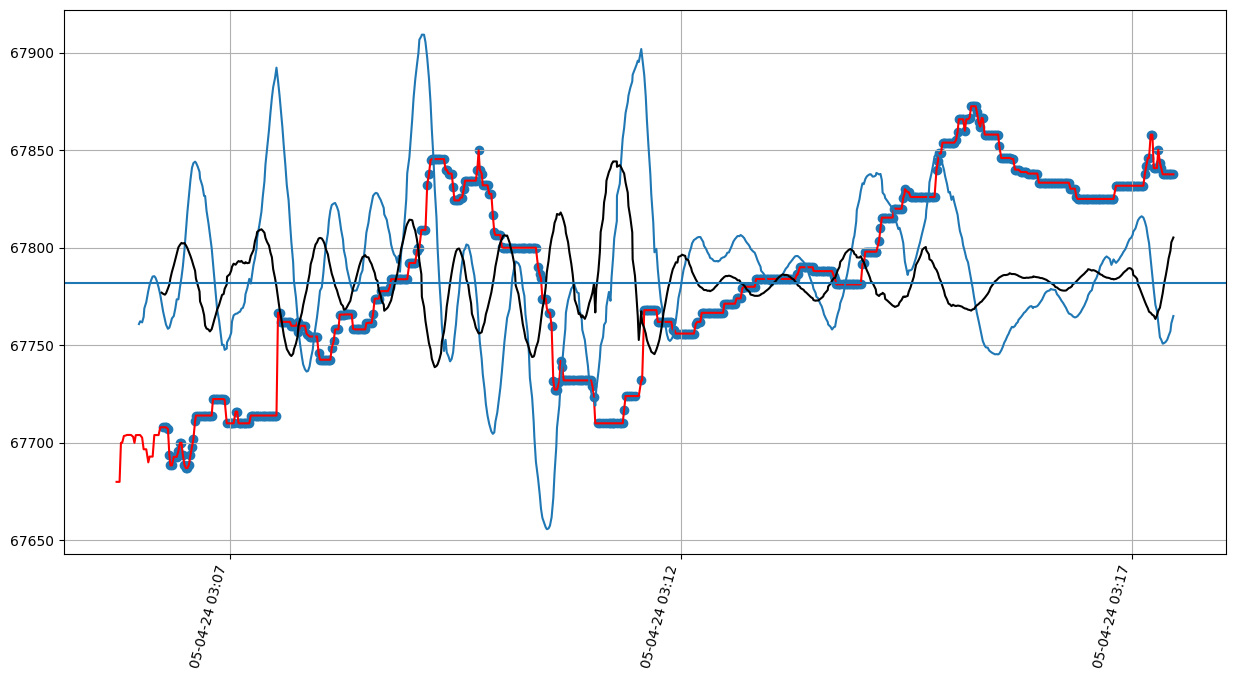

: 

In [77]:
## Conexión con Binance para descargar la lista de pares que binance maneja
from binance import Client
client = Client()


##################################################################################################################################
# Descarga y limpieza de datos de 5 días en adelante
##################################################################################################################################

smooth_interval = 60
smooth_exp = 3

# recent_data = pd.DataFrame(client.get_historical_klines('BTCUSDT','1m','1 day ago UTC'))
recent_data = pd.read_csv('../csvs/streaming/BTCUSDT.csv')
# recent_data = recent_data.iloc[:,:6]
recent_data.columns = ['Tiempo','Par','Precio']
# recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo,unit='ms')
recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
recent_data = recent_data.set_index('Tiempo')
recent_data['Precio'] = recent_data.Precio.astype(float)
recent_data = recent_data.reset_index()
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Precio,smooth_interval,smooth_exp)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,smooth_exp)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,smooth_exp)
# recent_data


##################################################################################################################################
# Gráfica final del backtesting sobre nuestro análisis con puntos de compra y venta.
##################################################################################################################################
a = 0
d = 700

min_max_sd = pd.DataFrame(columns=['Derivada'])
min_max_sd['Derivada'] = recent_data[a:a+d].SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
lista_min_max = min_max_sd[(min_max_sd['Derivada'] >= -0.1) & (min_max_sd['Derivada'] <= 0.1)]
lista_min_max = lista_min_max.index.tolist()

mp = recent_data.Precio[a:a+d].mean()
# plt.axvline(halving_dates['Halving_Dates'][2])
# plt.axvline(halving_dates['Halving_Dates'][3])
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[a:a+d],recent_data.Precio[a:a+d].multiply(1),color='red')
plt.plot(recent_data.Tiempo[a:a+d],recent_data.PD_Interpolacion[a:a+d].multiply(30)+mp)
plt.plot(recent_data.Tiempo[a:a+d],recent_data.SD_Interpolacion[a:a+d].multiply(100)+mp,color='k')
# for i in recent_data.Tiempo.iloc[lista_min_max]:
#     plt.axvline(i)
plt.scatter(recent_data.Tiempo.iloc[lista_min_max],recent_data.Precio.iloc[lista_min_max])
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
# plt.axvline(6500)
plt.show